## SVM Linear Kernal  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

random.seed(50)

# Importing the dataset
dataset = pd.read_csv('../input/PS_20174392719_1491204439457_log.csv')


In [2]:
# lets check the shape of the data
dataset.shape

(6362620, 11)

In [3]:
#lets look into some sample data
dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
#lets see the statistical features
dataset.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
## dropping of some unnecessary columns
dataset.drop('nameOrig', axis=1, inplace=True)
dataset.drop('nameDest', axis=1, inplace=True)
dataset.drop('isFlaggedFraud', axis=1, inplace=True)

In [6]:
sample_dataframe = dataset.sample(n=100000)
X = sample_dataframe.iloc[:, :-1].values
y = sample_dataframe.iloc[:, 7].values

print(sample_dataframe.isFraud.value_counts())

0    99873
1      127
Name: isFraud, dtype: int64


In [7]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder = LabelEncoder()
X[:, 1] = labelencoder.fit_transform(X[:, 1])
onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()

# Avoiding the Dummy Variable Trap
X = X[:, 1:]

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:385: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [8]:
# Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

counts = np.unique(y_train, return_counts=True)


In [9]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)
print(counts)

(array([0, 1]), array([69910,    90]))


In [10]:
# Fitting Kernel SVM to the Training set
from sklearn.svm import LinearSVC
from imblearn.under_sampling import NearMiss
from imblearn import over_sampling as os
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import RandomOverSampler

In [11]:
# Apply the sampling
ada = ADASYN()
X_resampled, y_resampled = ada.fit_sample(X_train, y_train)
count = np.unique(y_resampled, return_counts=True)

# Create a pipeline

pipeline4 = make_pipeline(ADASYN(),LinearSVC(random_state=1))
pipeline4.fit(X_train, y_train)
print(count)

(array([0, 1]), array([69910, 69898]))


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [12]:
# Classify and report the results
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, pipeline4.predict(X_test)))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.93      0.94      0.97      0.94      0.88     14982
          1       0.02      0.94      0.93      0.03      0.94      0.88        18

avg / total       1.00      0.93      0.94      0.96      0.94      0.88     15000



In [13]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, precision_score,auc,roc_auc_score,roc_curve,recall_score
cm = confusion_matrix(y_val, pipeline4.predict(X_val))
roc = roc_auc_score(y_val, pipeline4.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val, pipeline4.predict(X_val))
roc_auc = auc(fpr,tpr)

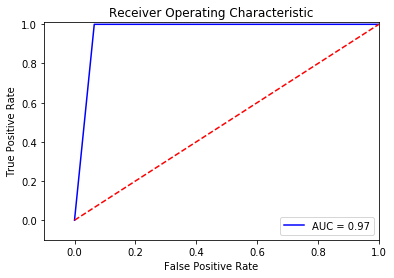

In [14]:
# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Linear Kernel SVM = AUC 0.96

 Recommendation
 Future enhancement :
# Boosting algorithm like (LGB/XGB/CATBOOST) is certainly a must try
# NN based classification model. 
    
